# Part C Multiclass Perceptron
## Question 3
In this part, you are asked to demonstrate your understanding of linear models for
classification. You expand the binary-class perceptron algorithm that is covered in Activity 1
of Module 3 into a multiclass classifier.


### Multiclass Perceptron

In [1]:
require(ggplot2)

set.seed(1234);
# load datasets
testData <- read.csv("C:/Users/aaron/OneDrive/Documents/Monash Data Science/Algorithms For Data Analysis/Assignment 2/Dataset/Task2C_test.csv")
testLabel <- testData[, 'y']
testData <- testData[, 1:4]
trainData <- read.csv("C:/Users/aaron/OneDrive/Documents/Monash Data Science/Algorithms For Data Analysis/Assignment 2/Dataset/Task2C_train.csv ")
trainLabel <- trainData[, 'y']
trainData <- trainData[, 1:4]


Loading required package: ggplot2


In [2]:
mCPerceptron <- function(trainData,trainLabel,eta=0.1,iterMax=100) {

    # get levels
    levels_ <- levels(trainLabel);


    # store weight vectors for each level
    wK_ <- matrix(, nrow = length(levels_), ncol = ncol(trainData));

    # instantiate weight vectors
    for (i in 1:length(levels_)) {

        wK_[i,] <- runif(ncol(wK_));

    }

    # initialise phi
    phi_ <- as.matrix(trainData);

    # iteration counter
    iter_ <- 1;

    # max iterations
    iterMax_ <- iterMax;

    # termination flag
    term_ <- FALSE;

    # learning rate
    eta_ <- eta;

    error_ <- 0;

    # initiate main loop
    while (term_) {

        # randomise data points
        trIndex_ <- sample(1:nrow(trainData), nrow(trainData));
        phi_ <- phi_[trIndex_,];
        trLab_ <- trainLabel[trIndex_];

        # numerify labels
        trLab_ <- as.numeric(trLab_);

        # visit each datapoint
        for (n in 1:nrow(trainData)) {

            # get results of weight vectors
            pred_ <- wK_ %*% phi_[i,];

            # get the class of the predition
            predClass_ <- which.max(pred_);

            # if the class predicted does not match the label update the weights
            if (predClass_ != trLab_[i]) {

                # update weights of the class that produced the largest dot product.
                wK_[predClass_,] <- wK_[predClass_,] - eta_ * phi_[i,]

                # update the weights of the true class.
                wK_[trLab_[i],] <- wK_[trLab_[i],] + eta_ * phi_[i,];

            }
        }


        # increment iterator
        iter_ <- iter_ + 1;
        term_ <- iter_ >= iterMax_;

    }

    return(wK_);

}


In [3]:
mCPredictions <- function(data,labels,weights) {

    # container for predictions
    predictions_ <- matrix(, nrow = nrow(data), ncol = 1);

    # get label levels
    levels_ <- levels(labels);

    err_ <- 0;

    for (n in 1:nrow(data)) {

        # predict
        pred_ <- weights %*% as.matrix(data)[n,];

        # assign class
        predictions_[n] <- levels_[which.max(pred_)];

        # if error, increment error count.
        if (levels_[which.max(pred_)] != labels[n]) {
            err_ = err_ + 1;
        }

    }
    

    # errors
    #err_ <- sum(predictions_!=labels)

    lst_ <- list("errors" = err_/nrow(data)*100, "predictions" = predictions_);

    return(lst_);

}


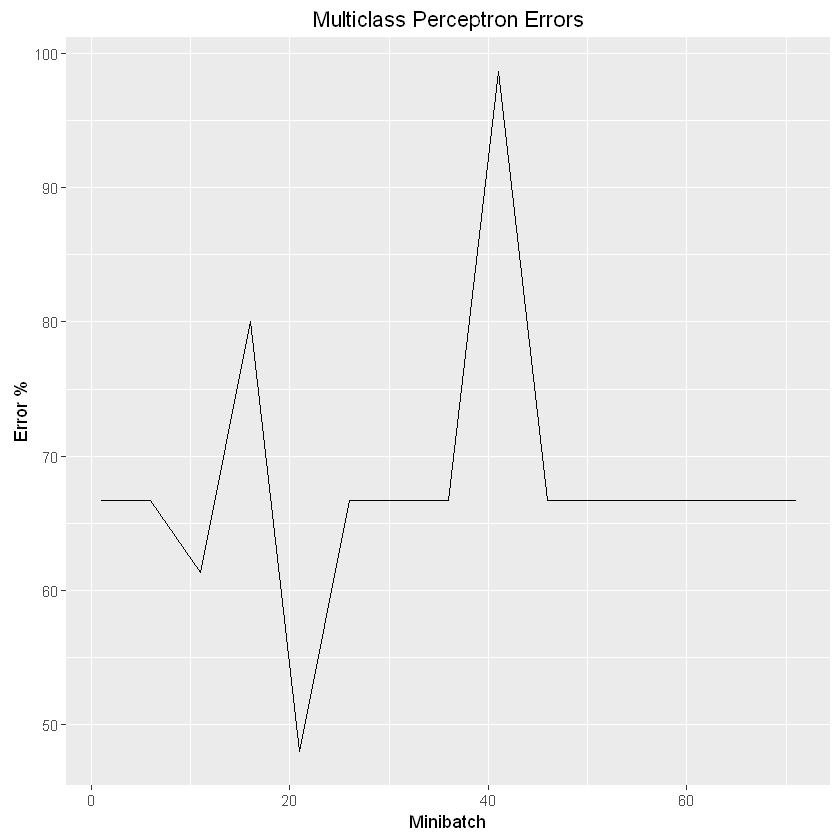

In [4]:
# container for minibatch errors
errTot_ <- matrix(,nrow=length(seq(1,nrow(trainData),5)),ncol = 2)
index_ <- 1; # indexer


for (i in seq(1, nrow(trainData), 5)) {

    wts_ <- mCPerceptron(trainData[1:i + 4,], trainLabel[1:i + 4]);
    res_ <- mCPredictions(testData, testLabel, wts_);

    errTot_[index_,1] <- i
    errTot_[index_,2] <- res_$errors;

    index_ = index_ + 1;

}

# plot
df_ <- as.data.frame(errTot_);
ggplot(data = df_, aes(x = df_$V1, y = df_$V2)) + geom_line() + ylab("Error %") + xlab("Minibatch") + ggtitle("Multiclass Perceptron Errors");

### One Vs One Perceptron

In [5]:
target <- "C1"
oneOneClassifier <- function(trainData,trainLabel,testData,testLabel,eta,epsilon,iterMax) {

    # dermine k
    k_ <- length(levels(trainLabel));

    # container to store weights of K(K-1)/2 classifiers
    w__ <- matrix(0, nrow = k_ * (k_ - 1) / 2, ncol = ncol(trainData) + 1);

    # build K(K-1)/2 classifiers
    for (m in 1:k_*(k_ - 1) / 2) {
        w__[m,] <- binaryClassifier(trainData, trainLabel, eta, epsilon, iterMax, levels(trainLabel)[m]);
    }

    # predict test set using each classifier.
    # if the result is positive, then the prediction is that class.

    res_ <- matrix(, nrow = nrow(testData), ncol = k_ * (k_ - 1) / 2);
    for (m in 1:k_ * (k_ - 1) / 2) {

        res_[, m] <- as.matrix(cbind(1, testData)) %*% w__[m,];
    }

    preds_ <- matrix(, nrow = nrow(testData), ncol = 1);

    # 
    for (i in 1:nrow(testData)) {

        tmp_ <- which(res_[i,] > 0);

        if (length(tmp_) >= 2) {
            preds_[i] <- "confusion";
        } else {
            preds_[i] <- levels(testLabel)[tmp_];
        }

    }

    return(preds_);

}
binaryClassifier <- function(trainData,trainLabel,eta,epsilon,iterMax,target) {

    # make a binary classifier.
    # create phi
    phi_ <- as.matrix(cbind(1, trainData));

    eta_ <- eta;
    epsilon_ <- epsilon;
    iterMax_ <- iterMax;

    # rename the labels with +1 as the target class, and others as -1
    levels(trainLabel)[levels(trainLabel) == target] <- 1;
    levels(trainLabel)[levels(trainLabel) != 1] <- -1;

    # cast numeric
    trLab_ <- as.character(trainLabel)
    trLab_ <- as.numeric(trLab_);

    # weights container
    w_ <- matrix(, nrow = iterMax_, ncol = ncol(phi_));

    # initialise randome values for weights.
    w_[1,] <- runif(ncol(phi_));

    # container for errors
    err_ <- matrix(0, nrow = iterMax_, ncol = 1);

    # get random guess error
    err_[1] <- sum((phi_ %*% w_[1,]) * trLab_ < 0) / nrow(trainData) * 100;

    iter_ <- 1;
    term_ <- FALSE;

    while (!term_) {

        # shuffle data
        trainIndex <- sample(1:nrow(trainData), replace = FALSE);
        phi_ <- phi_[trainIndex,];
        trLab_ <- trLab_[trainIndex];

        for (n in 1:nrow(trainData)) {

            # termination check
            if (iter_ == iterMax_) {
                break
            };

            # search misclassified
            if ((w_[iter_, ] %*% phi_[n, ]) * trLab_[n] < 0) {

                # increment iteration
                iter_ <- iter_ + 1;

                # update weights
                w_[iter_,] <- w_[iter_ - 1,] + eta_ * phi_[n,] * trLab_[n];

                # update errors
                err_[iter_] <- sum((phi_ %*% w_[iter_,]) * trLab_ < 0) / nrow(trainData) * 100;
            }

        }

        # decay eta
        eta_ = eta_ * 0.99;

        # refresh termination
        term_ <- iter_ >= iterMax_ | abs(sum((phi_ %*% w_[iter_,]) * trLab_ < 0) / nrow(trainData) - sum((phi_ %*% w_[iter_ - 1,]) * trLab_ < 0) / nrow(trainData));
    }

    coeffs_ <- w_[iter_,];

    return(coeffs_);

}

In [6]:
table(oneOneClassifier(trainData,trainLabel,testData,testLabel,0.1,0.001,100))


       C1 confusion 
       25        50 